# Dados e Aprendizagem Automática
### Part VII

### Imports and installations

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import xgboost as xgb

%matplotlib inline

/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FE and EDA on Titanic Dataset

Load the CSV - *Titanic*

In [4]:
df = pd.read_csv("titanic.csv")

Inspect data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Plot the distribution of *Age*, *SibSp*, *Parch*, and *Fare*

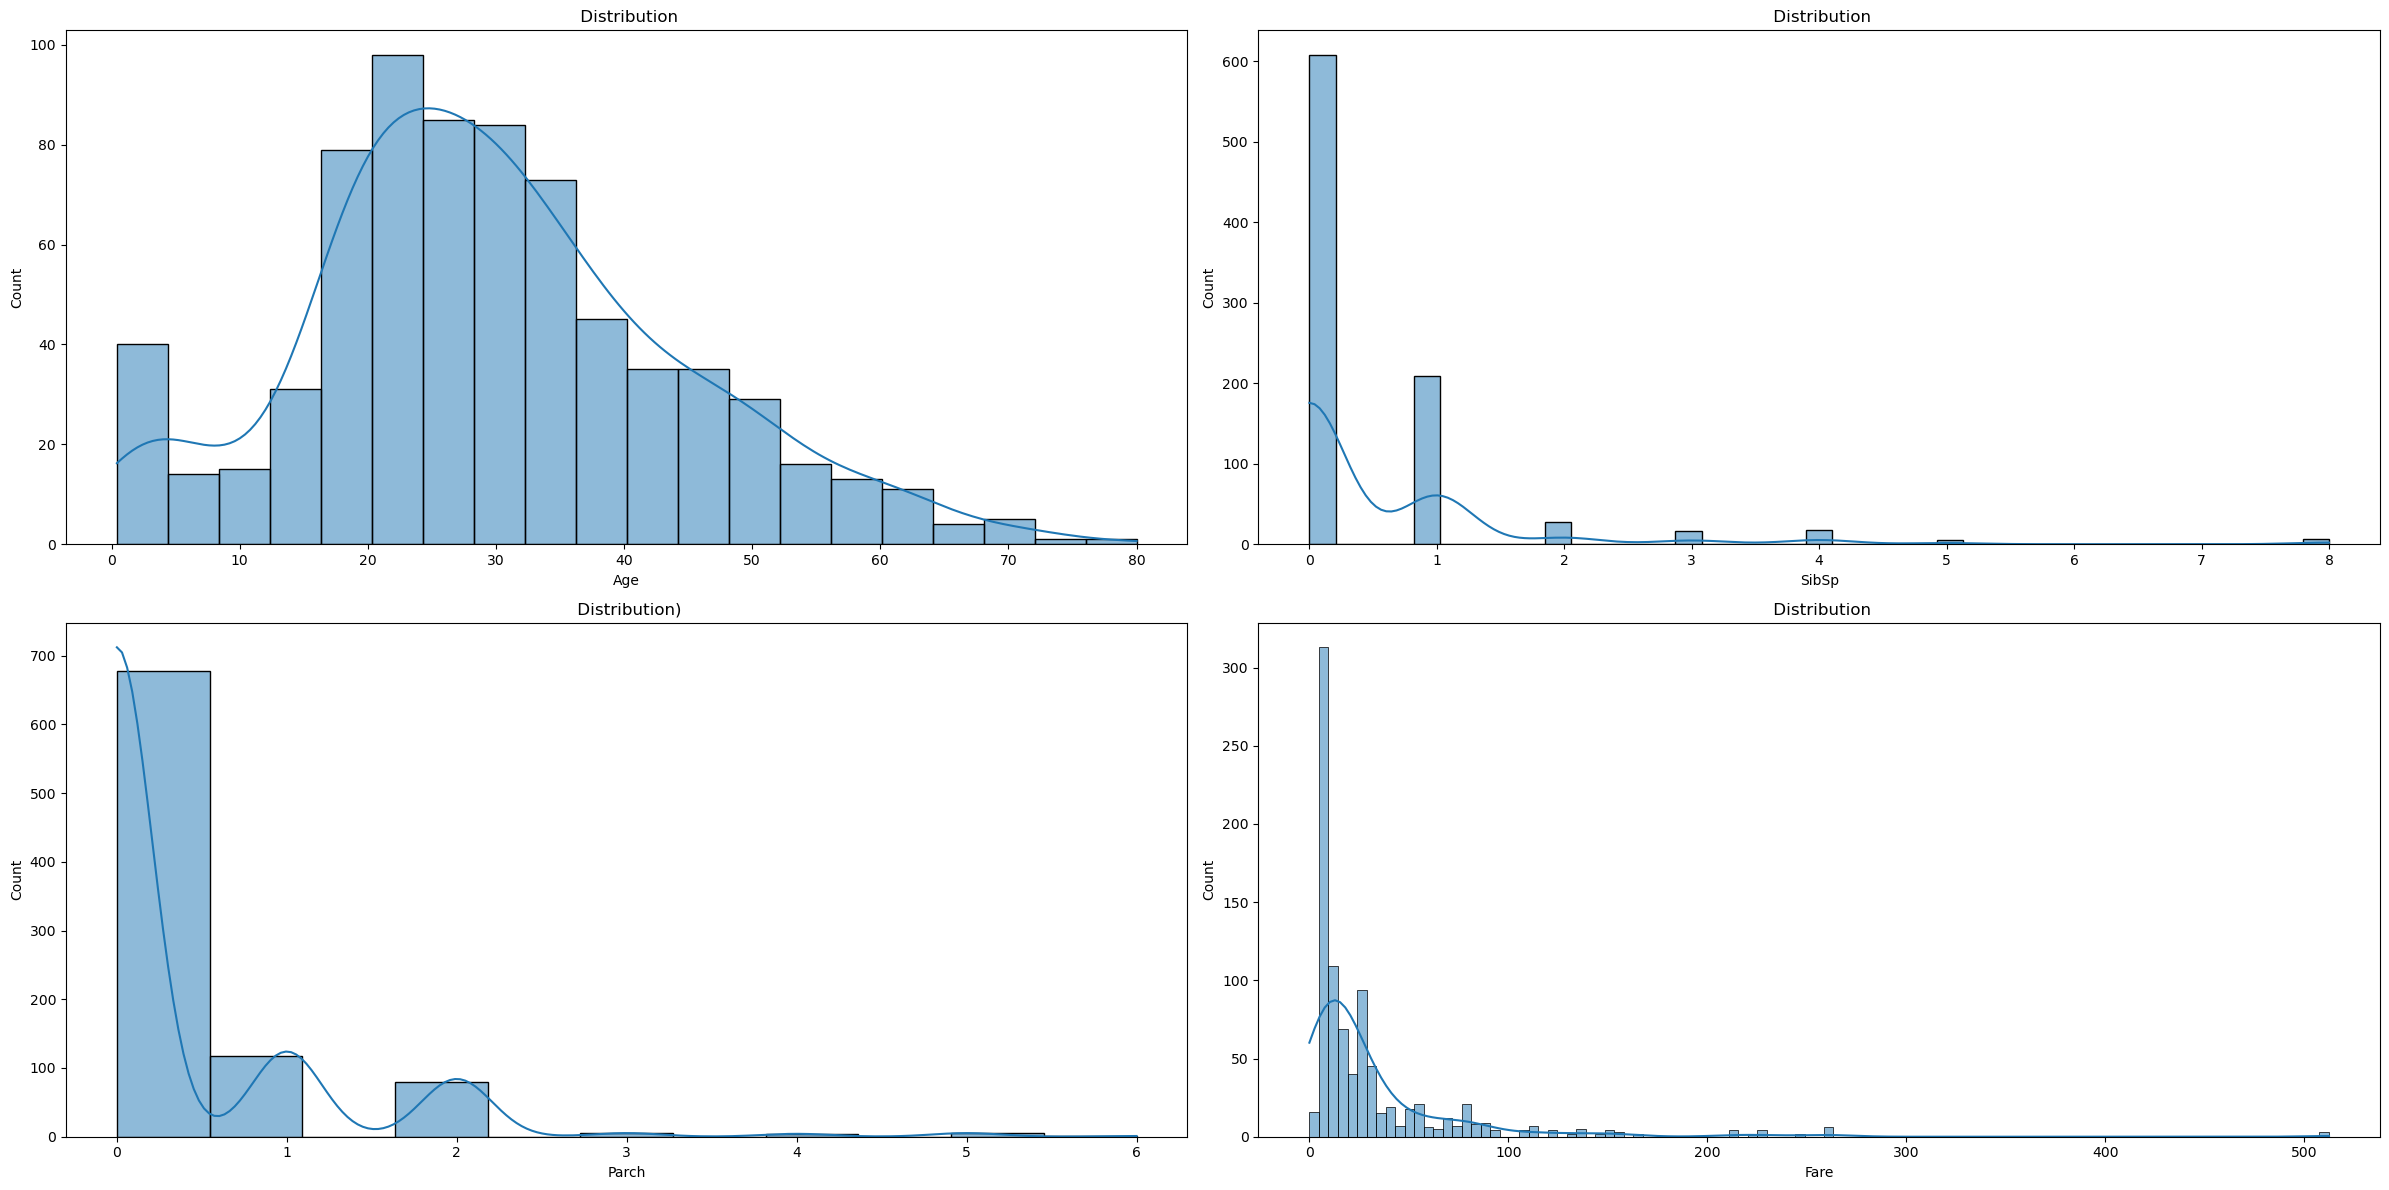

In [7]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# Age Distribution
sns.histplot(data=df, x='Age', kde=True, ax=axes[0, 0])
axes[0, 0].set_title(' Distribution')

# SibSp Distribution
sns.histplot(data=df, x='SibSp', kde=True, ax=axes[0, 1])
axes[0, 1].set_title(' Distribution')

# Parch Distribution
sns.histplot(data=df, x='Parch', kde=True, ax=axes[1, 0])
axes[1, 0].set_title(' Distribution)')

# Fare Distribution
sns.histplot(data=df, x='Fare', kde=True, ax=axes[1, 1])
axes[1, 1].set_title(' Distribution')

plt.tight_layout()
plt.show()

- ***Age* Distribution:** normally distributed with some outliers towards older ages

- ***SibSp* Distribution:** skewed distribution with most values being 0 (indicating no siblings/spouses or parents/children onboard)

- ***Parch* Distribution:** skewed distribution with most of values being 0 (indicating no siblings/spouses or parents/children onboard)

- ***Fare* Distribution:** right-skewed distribution with some high values indicating expensive tickets

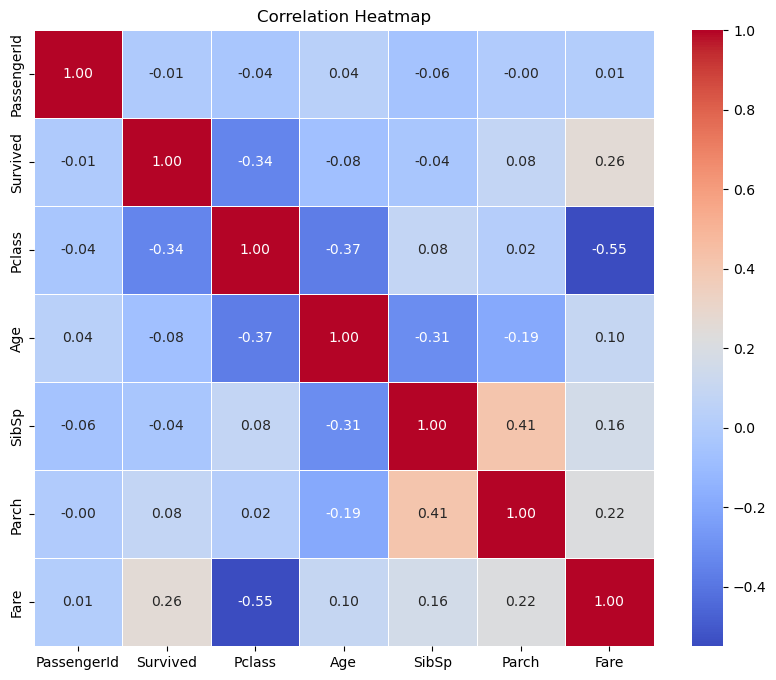

In [8]:
df2 = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis = 1)
correlation_matrix = df2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Missing values

In [9]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<Axes: >

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

*Age*, *Cabin* and *Embarked* have missing values

Feature *Age* - impute values using median

In [11]:
def med_impute_nan(df):
    med_impute = df.copy()
    med_impute["Age"] = med_impute["Age"].fillna(med_impute["Age"].median())
    return med_impute

In [12]:
med_impute = med_impute_nan(df)

In [13]:
med_impute.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
med_impute.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# checking standard deviation
print(df['Age'].std())
print(med_impute['Age'].std())

14.526497332334044
13.019696550973194


In [16]:
# plotting the variance difference
fig = plt.figure()
ax = fig.add_subplot(111)
df['Age'].plot(kind='kde', ax=ax)
med_impute['Age'].plot(kind='kde', label='Median Age', ax=ax, color='blue')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [17]:
df = med_impute
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Feature *Embarked* - deal with NaN values

In [18]:
df.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [19]:
emabark = df['Embarked'].dropna()

In [20]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [21]:
df['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [22]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.isnull().sum()

/tmp/ipykernel_14690/1025092037.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Feature *Cabin* - deal with NaN values

In [23]:
df['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [24]:
df['Cabin'].mode()

0        B96 B98
1    C23 C25 C27
2             G6
Name: Cabin, dtype: object

In [25]:
df['Cabin'].fillna(df['Cabin'].mode()[0], inplace=True)

/tmp/ipykernel_14690/1350131670.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'].fillna(df['Cabin'].mode()[0], inplace=True)


In [26]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [27]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S


Feature *Sex* - factorize: *male* = 1, *female* = 0

In [28]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Sex']

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

In [29]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,B96 B98,S


Features *Name*, *Ticket* and *Cabin* - drop

In [30]:
df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [31]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,0,38.0,1,0,71.2833,C
2,3,1,3,0,26.0,0,0,7.9250,S
3,4,1,1,0,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S


Feature *Embarked* - encode values: *S*, *C*, and *Q* using *LabelEncoder*

In [32]:
print(df["Embarked"].value_counts())

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [33]:
cols = ['Embarked']
le = LabelEncoder()

for col in cols:
    df[col] = le.fit_transform(df[col])
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


Correlation analysis of the features:

In [34]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Survived'].sort_values(ascending=False)
print("Correlation with target (Survived):\n", correlation_with_target)

Correlation with target (Survived):
 Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.064910
Embarked      -0.167675
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64


In this case, *Sex*, *Pclass*, and *Fare* have the highest absolute correlation values with *Survived*, suggesting that they may be useful for prediction.

Save dataset into a new file

In [35]:
# Convert data to DataFrame
t = pd.DataFrame(df)

# Specify the CSV file name
filename = 'titanic_ds.csv'

# Save to CSV
t.to_csv(filename, index=False, encoding='utf-8')

##  xboost Classifier

Data split

In [36]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 2022)

Train the model

In [38]:
#rf_model = RandomForestClassifier()
rf_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [39]:
rf_model.fit(X_train, y_train)

/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:08:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy of the model

In [40]:
rf_score = rf_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (rf_score * 100))

Accuracy: 80.22%


Save predictions to a file

In [41]:
op_rf = rf_model.predict(X_test)

In [42]:
op = pd.DataFrame(X_test['PassengerId'])
op['Survived'] = op_rf
op.to_csv("submission.csv", index=False)

## Feature Importance

Understanding which features influence predictions is fundamental. Feature importance analysis reveals the impact of factors like age, gender, and class on survival rates in theTitanic dataset.

### xgboost Importance

In [43]:
import time
import numpy as np

# Calcula o tempo de início
start_time = time.time()

# Obtém as importâncias das características
rf_importances = rf_model.feature_importances_

# Calcula o desvio padrão diretamente a partir das importâncias, se necessário
# No XGBoost, não há estimadores individuais como no RandomForest
std = np.std(rf_importances)

# Calcula o tempo decorrido
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Exibe as importâncias
print("Importâncias das características:", rf_importances)


Elapsed time to compute the importances: 0.001 seconds
Importâncias das características: [0.03113014 0.15520863 0.5791889  0.04552625 0.06663708 0.02443418
 0.04371546 0.05415941]


In [44]:
print("xgboost Feature Importances:\n", rf_importances )

xgboost Feature Importances:
 [0.03113014 0.15520863 0.5791889  0.04552625 0.06663708 0.02443418
 0.04371546 0.05415941]


### FI based on Mean Decrease in Impurity (MDI)

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [45]:
start_time = time.time()

mdi_importances = pd.Series(rf_model.feature_importances_, index=X_test.columns)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.001 seconds


In [46]:
print("Feature importances using MDI:\n",mdi_importances )

Feature importances using MDI:
 PassengerId    0.031130
Pclass         0.155209
Sex            0.579189
Age            0.045526
SibSp          0.066637
Parch          0.024434
Fare           0.043715
Embarked       0.054159
dtype: float32


In [47]:
fig, ax = plt.subplots()
mdi_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### FI based on Permutation Importance

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [48]:
from sklearn.inspection import permutation_importance

start_time = time.time()

result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 4.056 seconds


In [49]:
p_importances = pd.Series(result.importances_mean, index=X_test.columns)
print("Feature importances using PI:\n", p_importances )

Feature importances using PI:
 PassengerId    0.010075
Pclass         0.082090
Sex            0.173507
Age            0.032090
SibSp          0.019403
Parch         -0.000373
Fare           0.030224
Embarked       0.016045
dtype: float64


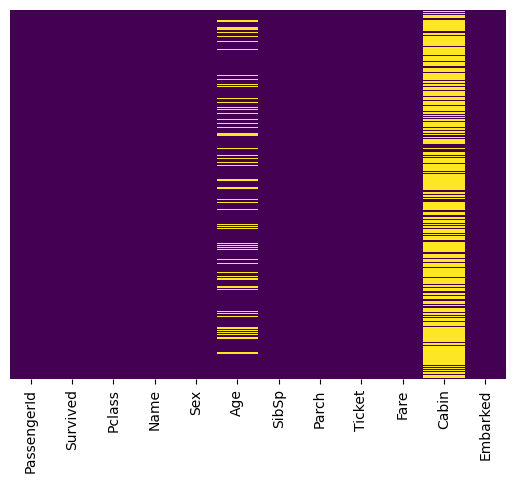

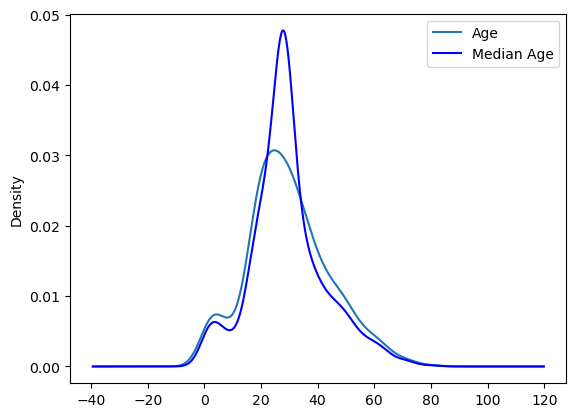

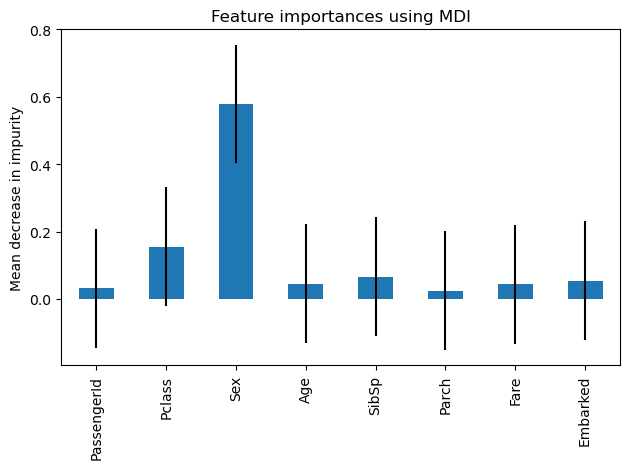

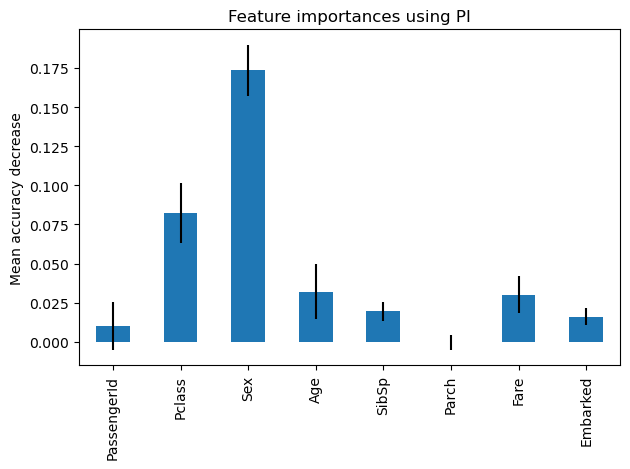

In [50]:
fig, ax = plt.subplots()
p_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using PI")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Which features have more importance?

Model specific vs. model agnostic

## SHAP (SHapley Additive exPlanations) Analysis

<code>pip install shap</code>

<code>conda install -c conda-forge shap</code>

In [51]:
shap.initjs()

In [52]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

### Local Interpretability

Local interpretability can be explained using the Titanic dataset. Let’s understand why a specific passenger, *ID=0*, didn't survived.

Forma de shap_values: (268, 8)
The passenger did not survive


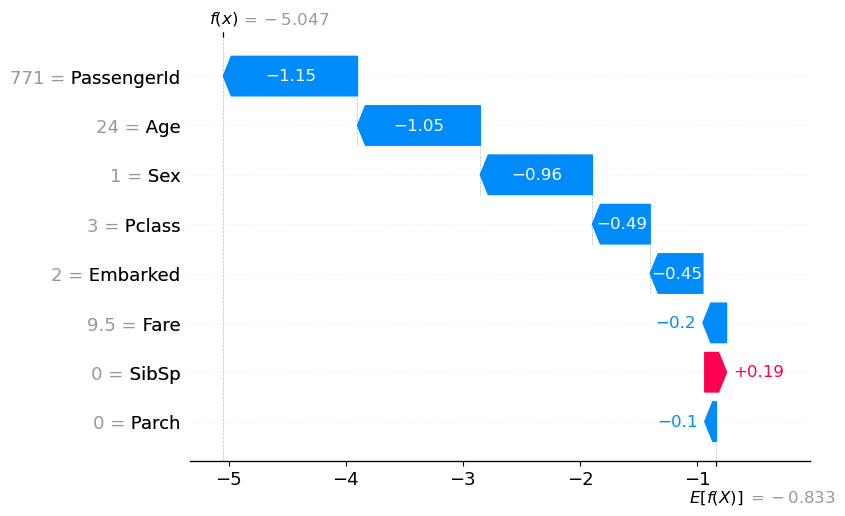

In [53]:
import shap

# Gera valores shap para as previsões no conjunto de teste
explainer = shap.Explainer(rf_model, X_test)
shap_values = explainer(X_test)

# Mostra a forma dos shap_values para entender a estrutura
print("Forma de shap_values:", shap_values.shape)

# Seleciona o passageiro e plota o gráfico waterfall
no = 0  # Altere o número para analisar diferentes passageiros
if rf_model.predict(np.expand_dims(X_test.iloc[no], axis=0))[0] == 1:
    print("The passenger survived")
else:
    print("The passenger did not survive")

# Plota o gráfico waterfall para o passageiro selecionado
shap.plots.waterfall(shap_values[no])


**Contribution of each feature to the survival of the passenger:**

*Negatively*:
- Sex = 1 – being male
- Fare = 9.5 – low fare
- Pclass = 3 – 3rd class
- Age = 24 – being young
- PassengerID = 771 – being among the last board the ship
- Parch = 0 – having no parent/children aboard
- Embarked = 2 – port of embarking 2

*Positively*:
- SibSp = 0 – having no siblings/spouse aboard

### Global Interpretability

Forma de shap_values: (268, 8)


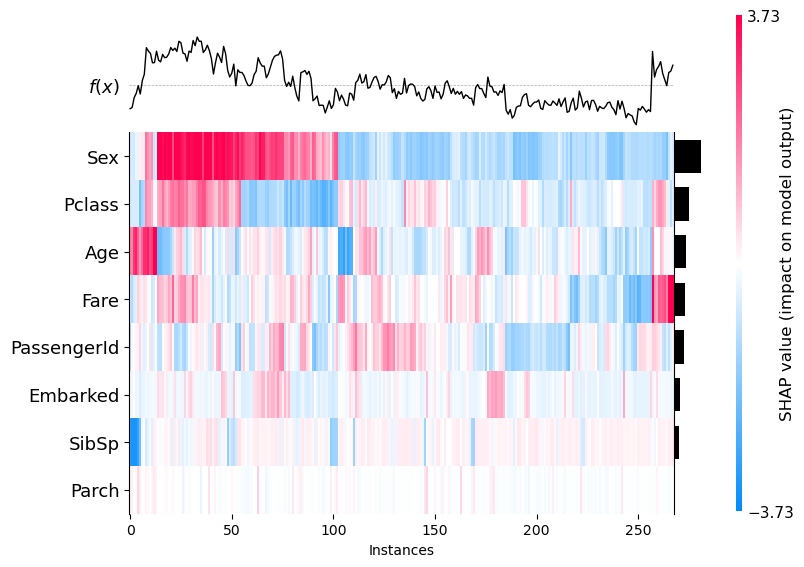

<Axes: xlabel='Instances'>

In [54]:
# Verifica a forma de shap_values
print("Forma de shap_values:", shap_values.shape)

# Plota o heatmap
shap.plots.heatmap(shap_values)

### SHAP Analysis - Feature wise

This tells us how each feature globally contributed to the model prediction.

**Sex**
- Being a male *(Sex=1)* reduced chances of survival. (Low SHAP Values)
- Being a female *(Sex=0)* increased chances of survival. (High SHAP Values)

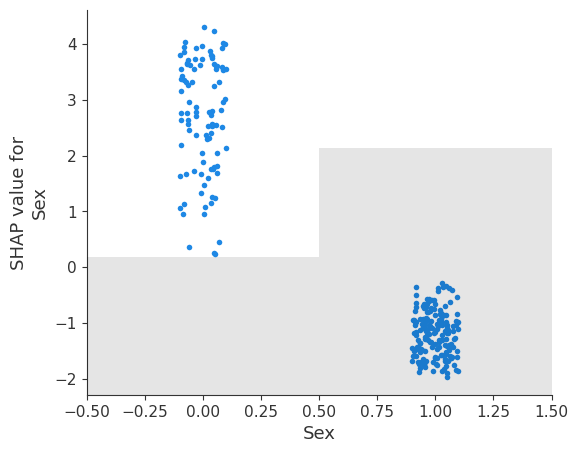

In [55]:
shap.plots.scatter(shap_values[:, "Sex"])

**Pclass**
- Being in the 1st class contributed highly positively to the survival.
- Being in the 2nd class contributed slightly positively to the survival.
- Being in the 3rd class contributed negatively to the survival.

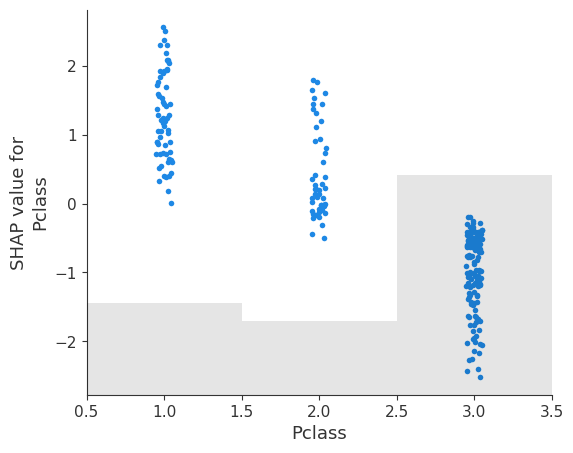

In [56]:
shap.plots.scatter(shap_values[:,"Pclass"])

**Age**
- Being a child below 10 years-old contributed highly towards survival.
- Being over 50 years-old contributed negatively to the survival.

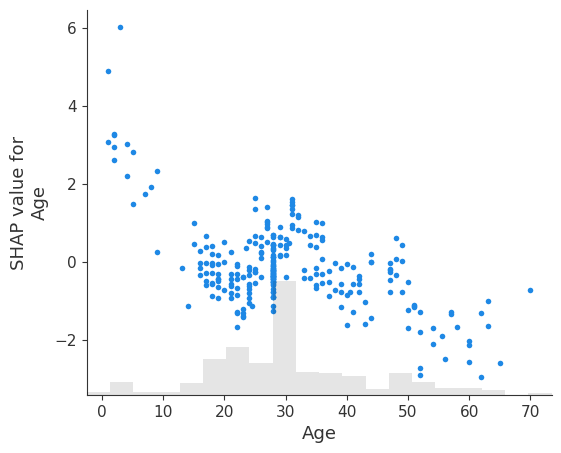

In [57]:
shap.plots.scatter(shap_values[:,"Age"])

**Fare**
- A low fare contributes negatively towards survival.
- A high fare (above 70) contributed positively towards survival.

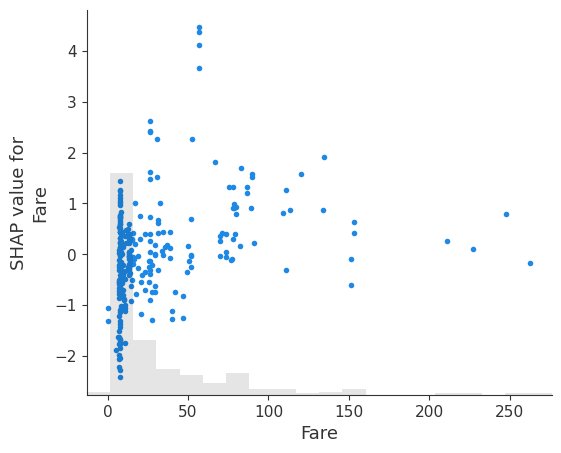

In [58]:
shap.plots.scatter(shap_values[:,"Fare"])

**SibSp** and **Parch**
- Higher sibling/spouse relation contributed negatively towards survival.
- Having zero or one sibling/spouse contributed positively towards survival.
- Having 1 or 2 parents/children contributed slightly positively towards survival.

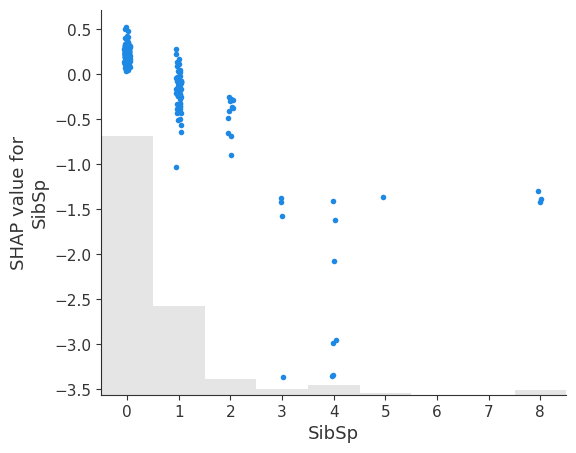

In [59]:
shap.plots.scatter(shap_values[:,"SibSp"])

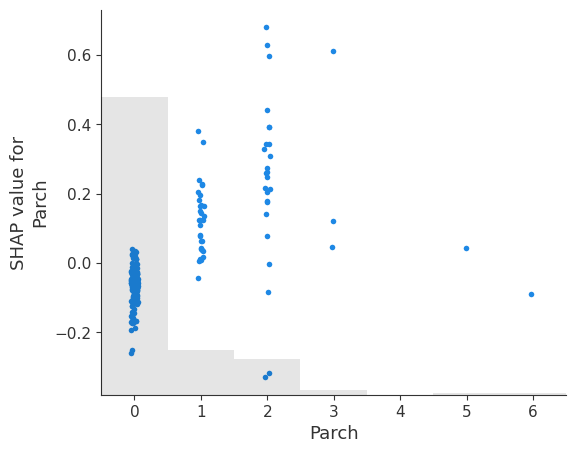

In [60]:
shap.plots.scatter(shap_values[:,"Parch"])

**Global interpretability** is vital for comprehending overall model behavior. Using **Partial Dependence Plots (PDPs)** with the Titanic dataset, we can visualize how changes in *SibSp* influence the model’s predictions.

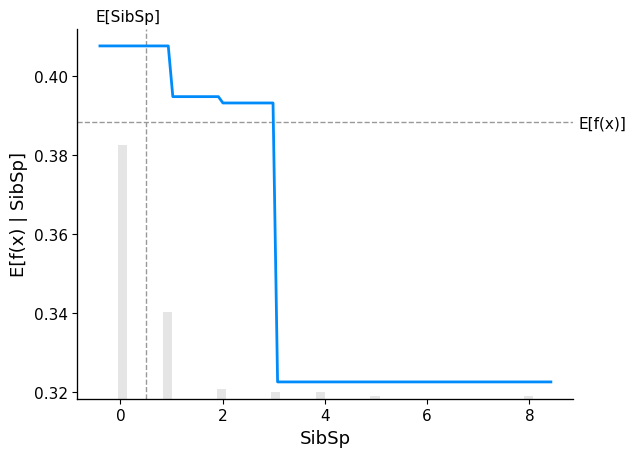

In [61]:
shap.partial_dependence_plot("SibSp", rf_model.predict , X_train, ice=False, model_expected_value=True, feature_expected_value=True,)

## Linear Regression

In [62]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [63]:
explainer = shap.LinearExplainer(lm, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train)


/home/eduardoascunha/miniconda3/envs/envNAME/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


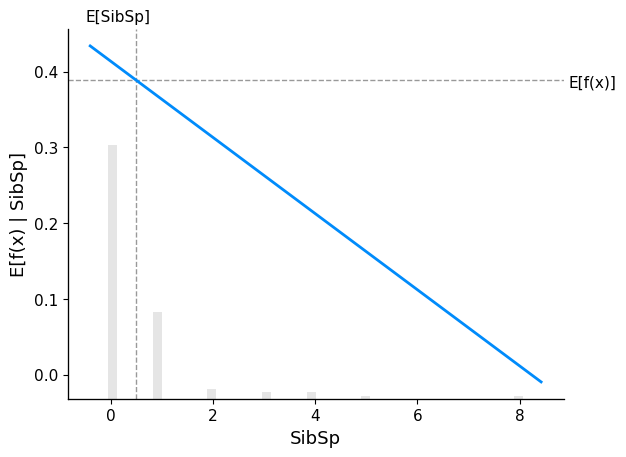

In [64]:
shap.partial_dependence_plot("SibSp", lm.predict, X_train, ice=False, 
                             model_expected_value=True, feature_expected_value=True,)

For one passenger:

In [65]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

For all training data set:

In [66]:
explainer_shap = shap.LinearExplainer(model=lm, masker=X_train)
shap_values = explainer_shap.shap_values(X_train)

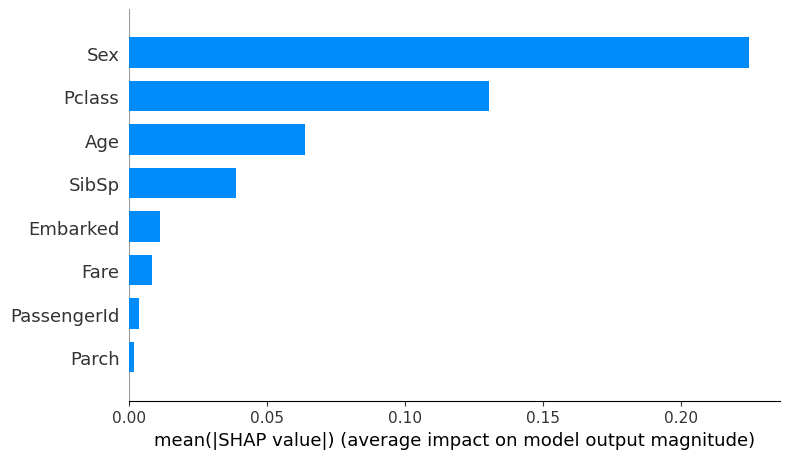

In [67]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

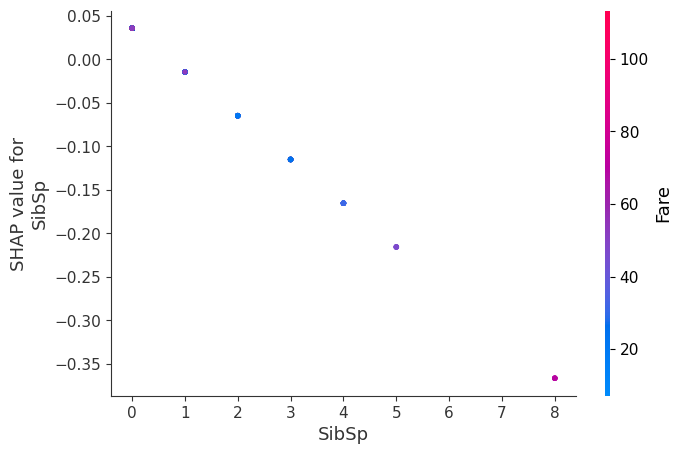

In [68]:
shap.dependence_plot("SibSp", shap_values, X_train)